In [172]:
import os
import re
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    Flatten,
    Conv2D,
    MaxPooling2D,
)
from sklearn.metrics import classification_report
import keras
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [173]:
import random

dirname = os.path.join(os.getcwd(), "data", "a_images")
directories = []
images = []
labels = []

print("Leyendo imágenes de:", dirname)

images_per_directory = {}
for root, _, filenames in os.walk(dirname):
    filenames = [f for f in filenames if re.search(r"\.(jpg|jpeg|png|bmp|tiff)$", f)]
    if filenames:
        images_per_directory[root] = filenames

min_images = min(len(files) for files in images_per_directory.values())
print(f"El mínimo número de imágenes por directorio es: {min_images}")

label_index = 0
for directory, files in images_per_directory.items():
    print(f"Procesando directorio: {directory}")
    selected_files = random.sample(files, min_images)
    for filename in selected_files:
        filepath = os.path.join(directory, filename)
        image = plt.imread(filepath)
        images.append(image)
        labels.append(label_index)
    label_index += 1

for i, label in enumerate(labels):
    print

print("Total de imágenes seleccionadas:", len(images))
print("Total de etiquetas creadas:", len(labels))

# Convertir listas a arrays de numpy
X = np.array(images, dtype=np.uint8)
y = np.array(labels)

Leyendo imágenes de: c:\Users\David\ia\cnn\data\a_images
El mínimo número de imágenes por directorio es: 22536
Procesando directorio: c:\Users\David\ia\cnn\data\a_images\combi
Procesando directorio: c:\Users\David\ia\cnn\data\a_images\cybertruck
Procesando directorio: c:\Users\David\ia\cnn\data\a_images\mini
Procesando directorio: c:\Users\David\ia\cnn\data\a_images\mx5
Procesando directorio: c:\Users\David\ia\cnn\data\a_images\vocho
Total de imágenes seleccionadas: 112680
Total de etiquetas creadas: 112680


In [174]:
# dirname = os.path.join(os.getcwd(), "data", "new_images")
# filenames = os.listdir(dirname)
# print(filenames)

# images = []
# directories = []
# dircount = []
# prevRoot = ""
# cant = 0

# print("leyendo imagenes de ", dirname)

# for root, dirnames, filenames in os.walk(dirname):
#     for filename in filenames:
#         if re.search(r"\.(jpg|jpeg|png|bmp|tiff)$", filename):
#             cant = cant + 1
#             filepath = os.path.join(root, filename)
#             image = plt.imread(filepath)
#             images.append(image)
#             b = "Leyendo..." + str(cant)
#             if prevRoot != root:
#                 prevRoot = root
#                 directories.append(root)
#                 dircount.append(cant)
#                 cant = 0
# dircount.append(cant)

# dircount = dircount[1:]
# dircount[0] = dircount[0] + 1
# print("Directorios leidos:", len(directories))
# print("Imagenes en cada directorio", dircount)
# print("suma Total de imagenes en subdirs:", sum(dircount))

In [175]:
# labels = []
# indice = 0
# for cantidad in dircount:
#     for i in range(cantidad):
#         labels.append(indice)
#     indice = indice + 1
# print("Cantidad etiquetas creadas: ", len(labels))

In [176]:
# sriesgos = []
# indice = 0
# for directorio in directories:
#     name = directorio.split(os.sep)
#     print(indice, name[len(name) - 1])
#     sriesgos.append(name[len(name) - 1])
#     indice = indice + 1

In [177]:
# y = np.array(labels)
# X = np.array(images, dtype=np.uint8)  # convierto de lista a numpy

classes = np.unique(y)
nClasses = len(classes)
print("Total number of outputs : ", nClasses)
print("Output classes : ", classes)

Total number of outputs :  5
Output classes :  [0 1 2 3 4]


In [178]:
train_X, test_X, train_Y, test_Y = train_test_split(X, y, test_size=0.2)
print("Training data shape : ", train_X.shape, train_Y.shape)
print("Testing data shape : ", test_X.shape, test_Y.shape)

Training data shape :  (90144, 80, 80, 3) (90144,)
Testing data shape :  (22536, 80, 80, 3) (22536,)


Text(0.5, 1.0, 'Ground Truth : 0')

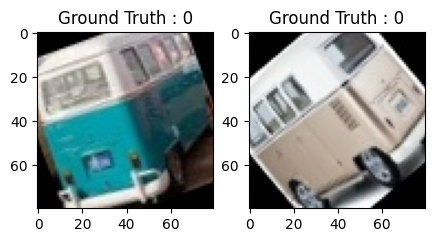

In [179]:
plt.figure(figsize=[5, 5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_X[0, :, :], cmap="gray")
plt.title("Ground Truth : {}".format(train_Y[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_X[0, :, :], cmap="gray")
plt.title("Ground Truth : {}".format(test_Y[0]))

In [ ]:
train_X = train_X.astype("float32")
test_X = test_X.astype("float32")
train_X = train_X / 255.0
test_X = test_X / 255.0
plt.imshow(test_X[0, :, :])

In [158]:
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)
print("Original label:", train_Y[0])
print("After conversion to one-hot:", train_Y_one_hot[0])

Original label: 2
After conversion to one-hot: [0. 0. 1. 0. 0.]


In [159]:
print(f"train_X shape: {train_X.shape}")
print(f"train_Y_one_hot shape: {train_Y_one_hot.shape}")
# Mezclar todo y crear los grupos de entrenamiento y testing
train_X, valid_X, train_label, valid_label = train_test_split(
    train_X, train_Y_one_hot, test_size=0.2, random_state=13
)
print(train_X.shape, valid_X.shape, train_label.shape, valid_label.shape)

train_X shape: (5008, 80, 80, 3)
train_Y_one_hot shape: (5008, 5)
(4006, 80, 80, 3) (1002, 80, 80, 3) (4006, 5) (1002, 5)


In [160]:
# declaramos variables con los parámetros de configuración de la red
INIT_LR = 1e-3  # Valor inicial de learning rate. El valor 1e-3 corresponde con 0.001
epochs = (
    100  # Cantidad de iteraciones completas al conjunto de imagenes de entrenamiento
)
batch_size = 32  # cantidad de imágenes que se toman a la vez en memoria

In [ ]:
car_model = Sequential(
    [
        Conv2D(
            32,
            (3, 3),
            activation="relu",
            input_shape=(80, 80, 3),
        ),
        MaxPooling2D((2, 2)),
        Conv2D(
            64,
            (3, 3),
            activation="relu",
        ),
        MaxPooling2D((2, 2)),
        Conv2D(
            128,
            (3, 3),
            activation="relu",
        ),
        MaxPooling2D((2, 2)),
        Conv2D(
            256,
            (3, 3),
            activation="relu",
        ),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        Flatten(),
        Dense(256, activation="relu"),
        Dense(128, activation="relu"),
        Dense(nClasses, activation="softmax"),
    ]
)

In [162]:
car_model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"],
)

In [163]:
data_gen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=15,
    zoom_range=[0.7, 1.4],
)
train_X = train_X.reshape(train_X.shape[0], 80, 80, 3)

data_gen_train = data_gen.flow(
    train_X, train_label, batch_size=batch_size, shuffle=False
)

In [164]:
car_train = car_model.fit(
    train_X,
    train_label,
    # data_gen_train,
    batch_size=batch_size,
    epochs=50,
    verbose=1,
    validation_data=(valid_X, valid_label),
)

Epoch 1/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.2515 - loss: 1.5717 - val_accuracy: 0.3443 - val_loss: 1.3913
Epoch 2/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.4791 - loss: 1.2216 - val_accuracy: 0.6218 - val_loss: 0.9378
Epoch 3/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.7161 - loss: 0.7429 - val_accuracy: 0.7764 - val_loss: 0.6141
Epoch 4/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.7995 - loss: 0.5536 - val_accuracy: 0.8124 - val_loss: 0.5251
Epoch 5/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.8307 - loss: 0.4371 - val_accuracy: 0.7784 - val_loss: 0.6454
Epoch 6/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.8804 - loss: 0.3311 - val_accuracy: 0.8443 - val_loss: 0.4586
Epoch 7/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.8941 - loss: 0.2833 - val_accuracy: 0.8423 - val_loss: 0.4379
Epoch 8/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.9148 - loss: 0.2441 - val_accu

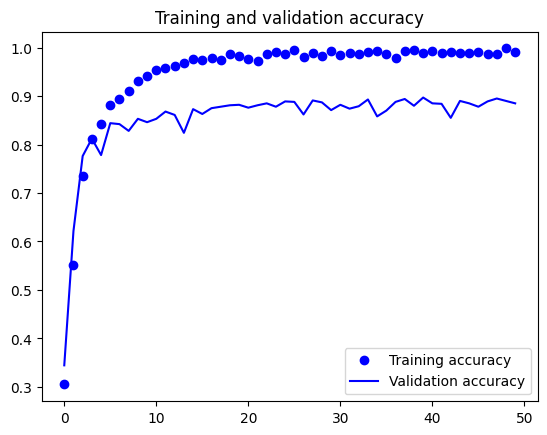

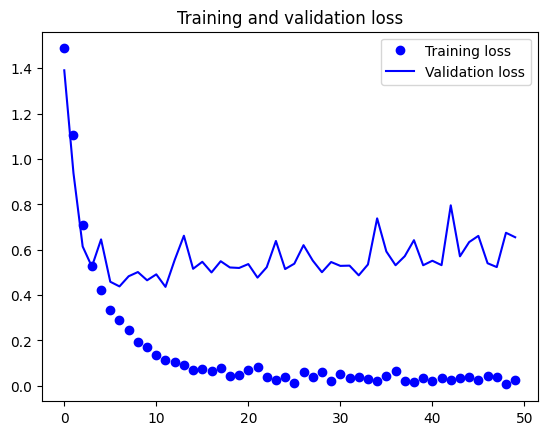

In [ ]:
accuracy = car_train.history['accuracy']
val_accuracy = car_train.history['val_accuracy']
loss = car_train.history['loss']
val_loss = car_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [166]:
car_model.save(os.path.join(os.getcwd(), "new.h5"))

In [167]:
test_eval = car_model.evaluate(test_X, test_Y_one_hot, verbose=1)

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8941 - loss: 0.7420


In [168]:
predicted_classes2 = car_model.predict(test_X)

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


In [169]:
predicted_classes = []
for predicted_car in predicted_classes2:
    predicted_classes.append(predicted_car.tolist().index(max(predicted_car)))
predicted_classes = np.array(predicted_classes)

In [170]:
target_names = ["Class {}".format(i) for i in range(nClasses)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.95      0.85      0.89       252
     Class 1       0.93      0.94      0.94       251
     Class 2       0.85      0.89      0.87       264
     Class 3       0.92      0.89      0.91       244
     Class 4       0.82      0.90      0.86       241

    accuracy                           0.89      1252
   macro avg       0.90      0.89      0.89      1252
weighted avg       0.90      0.89      0.89      1252



# Cargar modelo

In [171]:
from keras._tf_keras.keras.models import load_model, Sequential
import cv2

model: Sequential = load_model(os.path.join(os.getcwd(), "new-model.h5"))

image = cv2.imread(
    os.path.join(os.getcwd(), "data", "prueba", "combi.jpg"),
    cv2.IMREAD_GRAYSCALE,
)
image = cv2.resize(image, (80, 80))
plt.imshow(image, cmap="gray")
image = image.astype("float32")
image = image / 255.0
image = image.reshape(1, 80, 80, 1)

prediction = model.predict(image)
print(prediction)

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'c:\Users\David\ia\cnn\new-model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)